<a href="https://colab.research.google.com/github/HemiaoZhang/CEE316Project/blob/main/1_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.ma.core import shape
import os
import scipy

Mounted at /content/gdrive


In [10]:
%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316/Project
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/signedDistance.mat'
img_bi = []
img_rsd = []
with h5py.File(path, 'r') as file:
  img_bi = np.array(file['img_bi'][:]) # instancex512x512
  img_rsd = np.array(file['img_rsd'][:]) # instancex512x512

/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project
/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project


[PCA and SVD](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

In [57]:
def pca(X, n=50):
  '''
  take in flattened vector representation of image with size (ninstance, widthxwidth),
  plot up to n-th largest explained variance ratios, and
  return up to n-th largest eigenvalues and eigenvectors
  '''
  X = X - np.tile(np.mean(X, axis=0), (X.shape[0],1))
  Cov = np.cov(X.T) # numpy take different vectors row-wise
  sz = Cov.shape[0]
  L, V = scipy.linalg.eigh(Cov, subset_by_index=[sz-n, sz-1]) # largest n lambda and principal axes
  Var = L / np.trace(Cov) # explained variance ratio
  
  idx = np.argsort(-Var) # sorted in descending order
  cumVar = np.add.accumulate(Var[idx]) # accumulated explained variance ratio

  fig, ax1 = plt.subplots(figsize=(20, 5))
  ax2 = ax1.twinx()
  ax1.bar(range(len(Var)), Var[idx])
  ax2.plot(range(len(Var)), cumVar, 'y')
  plt.title(f'At {np.argmax(cumVar>0.95)}-th eigenvalue, 95% of total variance reached')
  ax1.set_ylabel('explained variance ratio', color='b')
  ax2.set_ylabel('cumulated explained variance ratio', color='y')

  pwd = os.getcwd()
  fig.savefig(pwd + f'/Figure/pca_expVar_{sz}_{n}_rsd.png')

  return L[idx], V[:,idx]

In [8]:
def reconstruct(x, V):
  '''
  reconstruct a compressed image collaped into subspace of
  n=len(L) principal axes
  @x size (wxw,)
  @V size (wxw, n), first n-th eigenvectors
  '''
  proj = np.matmul(x, V) # projection of x onto the subspace
  recon = np.zeros_like(x)
  for i in range(V.shape[1]): # loop over n pincipal directions
    recon += np.multiply(proj[i], V[:,i])
  return recon

Since 512x512=262144 results in a covariance matrix of size 262144-by-262144, which is very expensive to get up to n-th eigenvalues, only a portion of the sample domain w-by-w (even 256 is too large)

### Binary image

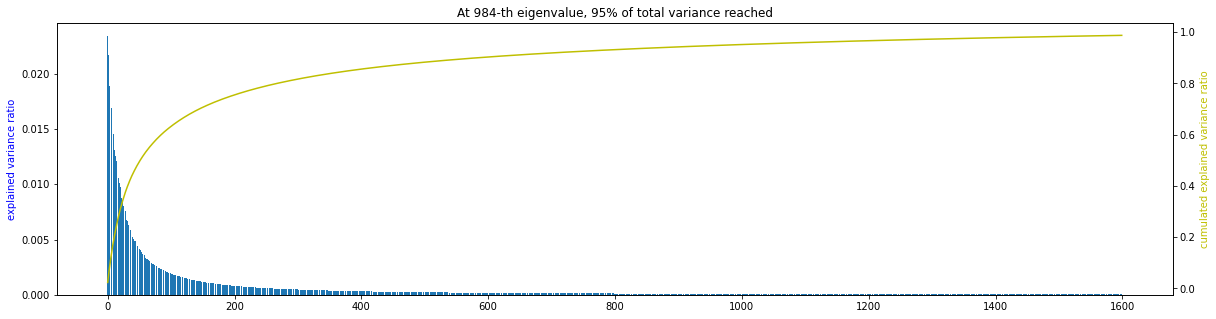

In [56]:
w = 128 # width of a subsection of the image
subimg = img_bi[:,:w,:w].reshape(-1, w*w) # size: instance, (wxw)
d, v = pca(subimg, n=1600)

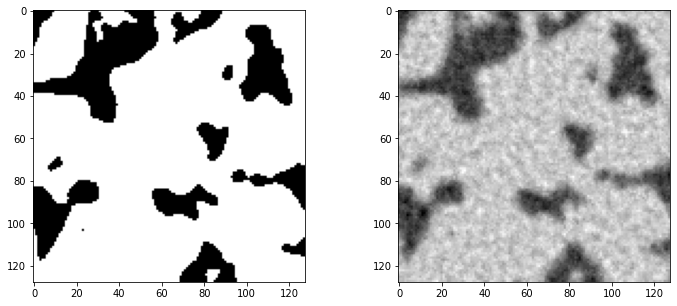

In [ ]:
x = img_bi[0,-w:,-w:].reshape(-1)
x_hat = reconstruct(x, v)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(w,w), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_hat.reshape(w,w), cmap='gray')

pwd = os.getcwd()
fig.savefig(pwd + f'/Figure/pca_recon_{v.shape[0]}_{v.shape[1]}_bi.png')

### Image after rescaled signed distance transformation [0,1]

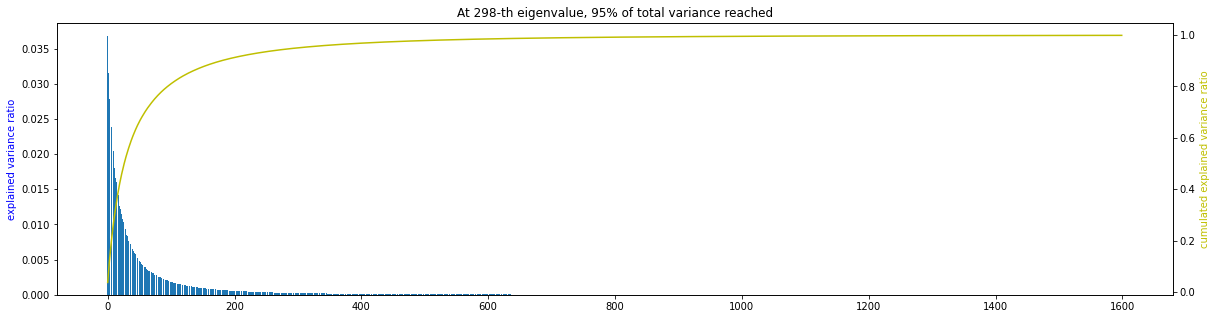

In [61]:
w = 128 # width of a subsection of the image
subimg = img_rsd[:,:w,:w].reshape(-1, w*w) # size: instance, (wxw)
d, v = pca(subimg, n=1600)

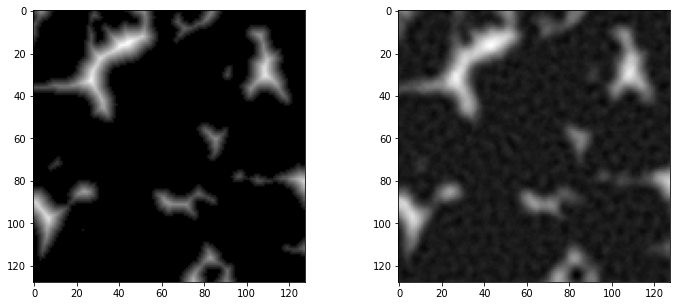

In [44]:
x = img_rsd[0,-w:,-w:].reshape(-1)
x_hat = reconstruct(x, v)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(w,w), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_hat.reshape(w,w), cmap='gray')

pwd = os.getcwd()
fig.savefig(pwd + f'/Figure/pca_recon_{v.shape[0]}_{v.shape[1]}_rsd.png')

## Trend of latent dimension w.r.t. image size w

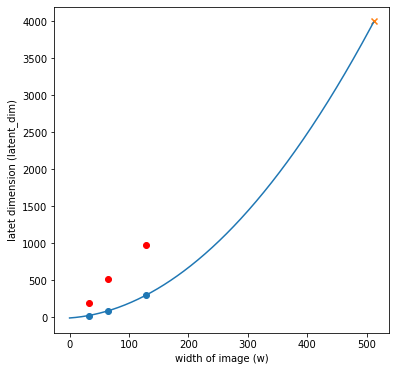

In [63]:
w_bi = np.array([32, 64, 128])
dim_bi = np.array([198, 520, 984])

w_rsd = np.array([32, 64, 128])
dim_rsd = np.array([25, 87, 298])

fig = plt.figure(figsize=(6,6))
plt.scatter(w_rsd, dim_rsd)
plt.scatter(w_bi, dim_bi, facecolors='r', edgecolors='r')
# fitting
plt.plot(range(512), np.poly1d(np.polyfit(w_rsd, dim_rsd, 2))(range(512)))
plt.scatter(512, 4000, marker='x')
plt.xlabel('width of image (w)')
plt.ylabel('latet dimension (latent_dim)')

pwd = os.getcwd()
fig.savefig(pwd + f'/Figure/estLatDim.png')

In [64]:
# end runtime
from google.colab import runtime

In [ ]:
runtime.unassign()